In [9]:
import csv
import math
import numpy as np
import time

# Qiskit básico
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram

# Operadores avanzados de Qiskit (más eficientes)
from qiskit.circuit.library import GroverOperator, MCMT, ZGate

# Simulador
from qiskit_aer import AerSimulator

print("Librerías cargadas correctamente.")

Librerías cargadas correctamente.


In [80]:
csvName = "database2m.csv"
LIMIT_RECORDS = 2000000

# 1. Cargar Base de Datos
database = []
try:
    with open(csvName, newline="") as f:
        reader = csv.DictReader(f)
        for i, row in enumerate(reader):
            if LIMIT_RECORDS and i >= LIMIT_RECORDS:
                break
            database.append(int(row["valor"]))
    print(f"Base de datos cargada. Registros totales en memoria: {len(database)}")
except FileNotFoundError:
    # Generación de datos dummy si no existe el archivo (para pruebas portátiles)
    print("Archivo no encontrado. Generando datos aleatorios para la prueba...")
    N_dummy = LIMIT_RECORDS if LIMIT_RECORDS else 1024
    database = list(range(N_dummy))
    print(f"Datos generados: {len(database)}")


# 1. Definir el valor que buscamos
target_value = 1642072

# 2. Buscar el índice de este valor en nuestra base de datos clásica (Preparación del Oráculo)
try:
    target_index = database.index(target_value)
    print(f"El valor {target_value} se encuentra en el índice: {target_index}")
except ValueError:
    print("El valor no está en la base de datos. Usando índice 0 para prueba.")
    target_index = 0

# 3. Configuración de Qubits basada en el TAMAÑO DE LA LISTA (Indices), no en el valor
N = len(database)
n_qubits = math.ceil(math.log2(N))

# 4. El estado objetivo ahora es el ÍNDICE en binario
target_bin = format(target_index, f'0{n_qubits}b')

print("--- CONFIGURACIÓN DE BÚSQUEDA POR ÍNDICE ---")
print(f"Total registros: {N}")
print(f"Qubits necesarios: {n_qubits}")
print(f"Estado objetivo (Índice binario): |{target_bin}⟩ (= {target_index})")

Base de datos cargada. Registros totales en memoria: 2000000
El valor 1642072 se encuentra en el índice: 781692
--- CONFIGURACIÓN DE BÚSQUEDA POR ÍNDICE ---
Total registros: 2000000
Qubits necesarios: 21
Estado objetivo (Índice binario): |010111110110101111100⟩ (= 781692)


In [81]:
def create_phase_oracle(n_qubits, target_str):
    """
    Crea un oráculo que invierte la fase solo del estado objetivo.
    Utiliza una compuerta multicontrolada Z (MCMT) que es eficiente en Qiskit.
    """
    qc = QuantumCircuit(n_qubits, name="Oracle")
    
    # Qiskit ordena los qubits del 0 al n (de derecha a izquierda en lectura binaria)
    # Invertimos los qubits que son '0' en el target para activar la compuerta de control
    reversed_target = target_str[::-1]
    
    for i, bit in enumerate(reversed_target):
        if bit == '0':
            qc.x(i)
            
    # Aplicamos una compuerta Z controlada por todos los qubits (MCMT)
    # Esto aplica la fase -1 si y solo si todos los qubits están en estado |1>
    qc.h(n_qubits-1)
    qc.mcx(list(range(n_qubits-1)), n_qubits-1)
    qc.h(n_qubits-1)
    
    # Deshacemos la inversión X (Uncomputation)
    for i, bit in enumerate(reversed_target):
        if bit == '0':
            qc.x(i)
            
    return qc

# Instanciamos el oráculo
oracle = create_phase_oracle(n_qubits, target_bin)

# Qiskit construye el Difusor automáticamente con GroverOperator
grover_op = GroverOperator(oracle)

print("--- CARACTERÍSTICAS DEL ORÁCULO Y DIFUSOR ---")
print(f"🔹 Oráculo: {oracle.num_qubits} qubits, {oracle.size()} instrucciones base.")
print(f"🔹 Difusor: Generado automáticamente por Qiskit (reflexión sobre la media).")
# Si quieres ver qué hay dentro del operador de Grover descomenta la siguiente línea:
print(grover_op.decompose().draw(output='text', fold=-1))

--- CARACTERÍSTICAS DEL ORÁCULO Y DIFUSOR ---
🔹 Oráculo: 21 qubits, 17 instrucciones base.
🔹 Difusor: Generado automáticamente por Qiskit (reflexión sobre la media).
global phase: π
          ┌───┐          ┌───┐┌───┐┌───┐               ┌───┐┌───┐     
 state_0: ┤ X ├───────■──┤ X ├┤ H ├┤ X ├────────────■──┤ X ├┤ H ├─────
          ├───┤       │  ├───┤├───┤├───┤            │  ├───┤├───┤     
 state_1: ┤ X ├───────■──┤ X ├┤ H ├┤ X ├────────────■──┤ X ├┤ H ├─────
          └───┘       │  ├───┤├───┤└───┘            │  ├───┤├───┤     
 state_2: ────────────■──┤ H ├┤ X ├─────────────────■──┤ X ├┤ H ├─────
                      │  ├───┤├───┤                 │  ├───┤├───┤     
 state_3: ────────────■──┤ H ├┤ X ├─────────────────■──┤ X ├┤ H ├─────
                      │  ├───┤├───┤                 │  ├───┤├───┤     
 state_4: ────────────■──┤ H ├┤ X ├─────────────────■──┤ X ├┤ H ├─────
                      │  ├───┤├───┤                 │  ├───┤├───┤     
 state_5: ────────────■──┤ H ├┤ X ├──

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_3804\2043693573.py:33: DeprecationWarning: The class ``qiskit.circuit.library.grover_operator.GroverOperator`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use qiskit.circuit.library.grover_operator instead.
  grover_op = GroverOperator(oracle)


In [82]:
# 1. Calcular iteraciones óptimas (aprox pi/4 * sqrt(N))
optimal_iterations = int(np.floor(np.pi / 4 * np.sqrt(2**n_qubits)))

# 2. Crear Circuito Principal
qc = QuantumCircuit(n_qubits)

# Paso A: Superposición Inicial (Hadamard en todos)
qc.h(range(n_qubits))

# Paso B: Aplicar Operador de Grover (Oráculo + Difusor) repetidamente
# Usamos .power() para no añadir las puertas una por una, manteniendo el circuito limpio
qc.compose(grover_op.power(optimal_iterations), inplace=True)

# Paso C: Medición
qc.measure_all()

print(f"--- ESTADÍSTICAS DEL CIRCUITO ---")
print(f"Iteraciones de Grover calculadas: {optimal_iterations}")
print(f"Profundidad del circuito (instrucciones): {qc.data.__len__()}") 
# Nota: La profundidad real transpilada sería mucho mayor.
print(f"Estimación: Simular {n_qubits} qubits con {optimal_iterations} iteraciones tomará tiempo.")

--- ESTADÍSTICAS DEL CIRCUITO ---
Iteraciones de Grover calculadas: 1137
Profundidad del circuito (instrucciones): 1180
Estimación: Simular 21 qubits con 1137 iteraciones tomará tiempo.


In [83]:
# Configuración del simulador
sim = AerSimulator()

# Transpilación (optimización para el simulador)
print("Transpilando circuito (esto optimiza las compuertas)...")
t_qc = transpile(qc, sim)

# Ejecución
print(f"Iniciando simulación con {n_qubits} qubits...")
start_time = time.time()

# Shots = número de veces que ejecutamos el experimento
# Con Grover ideal, la probabilidad es muy alta, así que 128 o 1024 sobran.
result = sim.run(t_qc, shots=1024).result()

end_time = time.time()
elapsed = end_time - start_time

print(f"Simulación completada en {elapsed:.4f} segundos.")

Transpilando circuito (esto optimiza las compuertas)...
Iniciando simulación con 21 qubits...
Simulación completada en 61.6700 segundos.


--- RESULTADOS DE LA BÚSQUEDA ---
Estado medido (Índice Binario): |01101110111010101010⟩
Índice Decimal Recuperado:      454314
Probabilidad:                   100.00%

🔍 Verificación: database[454314] = 684876
✅ ¡ÉXITO! Grover encontró el índice original correcto.


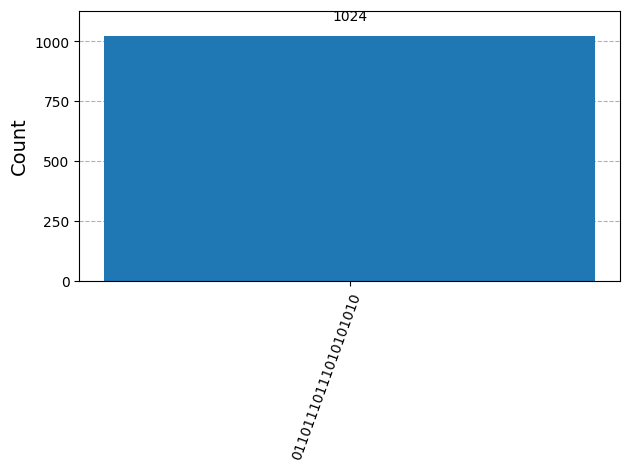

In [79]:

counts = result.get_counts()
most_probable_bin = max(counts, key=counts.get)
probability = counts[most_probable_bin] / 1024 * 100

# Convertimos el binario medido (que es un índice) a decimal
found_index = int(most_probable_bin, 2)

print("--- RESULTADOS DE LA BÚSQUEDA ---")
print(f"Estado medido (Índice Binario): |{most_probable_bin}⟩")
print(f"Índice Decimal Recuperado:      {found_index}")
print(f"Probabilidad:                   {probability:.2f}%")

# Verificación: Vamos a la base de datos a ver qué hay en ese índice
if found_index < len(database):
    recovered_value = database[found_index]
    print(f"\n🔍 Verificación: database[{found_index}] = {recovered_value}")
    
    if recovered_value == target_value:
        print("✅ ¡ÉXITO! Grover encontró el índice original correcto.")
    else:
        print("❌ El índice encontrado no contiene el valor esperado (posible ruido).")
else:
    print(f"⚠️ El índice medido ({found_index}) está fuera del rango de la base de datos.")

plot_histogram(counts)

In [49]:
import psutil
import platform
import os
from qiskit_aer import AerSimulator

def get_size(bytes, suffix="B"):
    """Convierte bytes a formato legible (GB, MB)"""
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f} {unit}{suffix}"
        bytes /= factor

print("="*40)
print("    INFORMACIÓN DE HARDWARE Y ENTORNO")
print("="*40)

# 1. Información del Sistema Operativo
uname = platform.uname()
print(f"💻 Sistema:       {uname.system}")
print(f"📦 Versión:       {uname.release}")
print(f"🏗️  Arquitectura:  {uname.machine}")

# 2. Información del Procesador (CPU)
print("-" * 40)
print(f"🧠 Procesador:    {uname.processor}")
print(f"Threads lógicos:  {psutil.cpu_count(logical=True)}")
print(f"Núcleos físicos:  {psutil.cpu_count(logical=False)}")
# Frecuencia actual (puede variar según el SO)
try:
    freq = psutil.cpu_freq()
    print(f"Frecuencia Max:   {freq.max:.2f} Mhz")
except:
    pass

# 3. Memoria RAM (Crítico para simulaciones cuánticas)
svmem = psutil.virtual_memory()
print("-" * 40)
print(f"💾 RAM Total:     {get_size(svmem.total)}")
print(f"🟢 RAM Disponible:{get_size(svmem.available)}")
print(f"🔴 RAM Usada:     {get_size(svmem.used)} ({svmem.percent}%)")

# 4. Detección de GPU (Nvidia)
print("-" * 40)
print("🎮 GPU Acceleration:")
try:
    # Intenta ejecutar comando de sistema nvidia-smi
    gpu_info = os.popen('nvidia-smi --query-gpu=name,memory.total --format=csv,noheader').read()
    if gpu_info:
        print(f"Detectada: {gpu_info.strip()}")
    else:
        print("No se detectó GPU NVIDIA accesible vía nvidia-smi.")
except:
    print("No se pudo verificar la GPU.")

# 5. Capacidades de Qiskit Aer
print("-" * 40)
sim = AerSimulator()
print(f"⚛️ Backend Qiskit: {sim.name}")
print(f"⚙️ Métodos disponibles: {sim.available_methods()}")
# Verifica si la GPU está habilitada en Qiskit
try:
    sim_gpu = AerSimulator(method='statevector', device='GPU')
    print("✅ Qiskit Aer tiene acceso a GPU.")
except:
    print("⚠️ Qiskit Aer está corriendo solo en CPU.")

print("="*40)

    INFORMACIÓN DE HARDWARE Y ENTORNO
💻 Sistema:       Windows
📦 Versión:       11
🏗️  Arquitectura:  AMD64
----------------------------------------
🧠 Procesador:    Intel64 Family 6 Model 151 Stepping 2, GenuineIntel
Threads lógicos:  12
Núcleos físicos:  8
Frecuencia Max:   2400.00 Mhz
----------------------------------------
💾 RAM Total:     23.71 GB
🟢 RAM Disponible:12.76 GB
🔴 RAM Usada:     10.96 GB (46.2%)
----------------------------------------
🎮 GPU Acceleration:
Detectada: NVIDIA GeForce RTX 2050, 4096 MiB
----------------------------------------
⚛️ Backend Qiskit: aer_simulator
⚙️ Métodos disponibles: ('automatic', 'statevector', 'density_matrix', 'stabilizer', 'matrix_product_state', 'extended_stabilizer', 'unitary', 'superop')
✅ Qiskit Aer tiene acceso a GPU.
